In [66]:
import pandas as pd
import psycopg2
import dotenv
import os
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat
import matplotlib.pyplot as plt
import numpy as np

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)

query = """
SELECT 
    s.id, s.game_id, s.period_id, s.seconds, 
    s.player_id, s.team_id, 
    s.start_x, s.start_y, s.end_x, s.end_y, 
    s.action_type, s.result, s.bodypart,
    p.player_name, t.team_name
FROM 
    spadl_actions s
LEFT JOIN 
    players p ON s.player_id = p.player_id
LEFT JOIN 
    teams t ON s.team_id = t.team_id
WHERE 
    s.start_x IS NOT NULL 
    AND s.end_x IS NOT NULL;
"""

# Load data into pandas DataFrame
df = pd.read_sql(query, conn)


# Preview the dataset
df.head()

C:\Users\ivanj\AppData\Local\Temp\ipykernel_11704\320294498.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,player_name,team_name
0,1,5oc8drrbruovbuiriyhdyiyok,1,0.0,bybggxgpzlr7xz2f1i3b7c0kp,1oyb7oym5nwzny8vxf03szd2h,52.500,34.000,32.865,30.464,0,1,0,H. Vetlesen,Club Brugge
1,2,5oc8drrbruovbuiriyhdyiyok,1,1.0,l6y4o9t2b0jxaxo85oztok45,1oyb7oym5nwzny8vxf03szd2h,32.865,30.464,32.445,33.864,21,1,0,B. Mechele,Club Brugge
2,3,5oc8drrbruovbuiriyhdyiyok,1,2.0,l6y4o9t2b0jxaxo85oztok45,1oyb7oym5nwzny8vxf03szd2h,32.445,33.864,58.170,43.588,0,1,0,B. Mechele,Club Brugge
3,4,5oc8drrbruovbuiriyhdyiyok,1,5.0,bybggxgpzlr7xz2f1i3b7c0kp,1oyb7oym5nwzny8vxf03szd2h,58.170,43.588,63.420,68.000,0,0,1,H. Vetlesen,Club Brugge
4,5,5oc8drrbruovbuiriyhdyiyok,1,19.0,4kuxth5k98x4cgfrfweu1u51,b7jmo07lqav0wfe2mtlzyspak,62.265,68.000,37.380,56.644,2,0,2,S. Walsh,Mechelen


In [67]:
import pandas as pd
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat

# Ensure correct column names for SPADL
df.rename(columns={
    'action_type': 'type_id',
    'result': 'result_id',
    'bodypart': 'bodypart_id'
}, inplace=True)

# Ensure consistent data types
df['type_id'] = df['type_id'].astype(int)  # Ensure type_id is int
df['result_id'] = df['result_id'].astype(int)  # Ensure result_id is int
df['bodypart_id'] = df['bodypart_id'].astype(int)  # Ensure bodypart_id is int

# Normalize direction of play
df_actions_ltr = spadl.play_left_to_right(df, home_team_id=df['team_id'].iloc[0])

# Add action names
df_actions_ltr = spadl.add_names(df_actions_ltr)

# Train xT model
xTModel = xthreat.ExpectedThreat(l=16, w=12)

# Ensure there are valid actions for training
if not df_actions_ltr.empty:
    xTModel.fit(df_actions_ltr)
else:
    raise ValueError("Training data is empty.")

# iterations:  35


In [68]:
spadl_actions_enemy_query = """
SELECT 
    s.id, s.game_id, s.period_id, s.seconds, 
    s.player_id, s.team_id, 
    s.start_x, s.start_y, s.end_x, s.end_y, 
    s.action_type, s.result, s.bodypart,
    p.player_name, t.team_name
FROM 
    spadl_actions s
JOIN 
    players p ON s.player_id = p.player_id
JOIN 
    teams t ON s.team_id = t.team_id
WHERE 
	s.team_id != 'bw9wm8pqfzcchumhiwdt2w15c'
	AND s.game_id IN (
		SELECT game_id
		FROM matches
		WHERE home_team_id = 'bw9wm8pqfzcchumhiwdt2w15c'
);"""

df_mov_actions = pd.read_sql(spadl_actions_enemy_query, conn)
# Ensure correct column names for SPADL
df_mov_actions.rename(columns={
    'action_type': 'type_id',
    'result': 'result_id',
    'bodypart': 'bodypart_id'
}, inplace=True)

# Ensure consistent data types
df_mov_actions['type_id'] = df_mov_actions['type_id'].astype(int)  # Ensure type_id is int
df_mov_actions['result_id'] = df_mov_actions['result_id'].astype(int)  # Ensure result_id is int
df_mov_actions['bodypart_id'] = df_mov_actions['bodypart_id'].astype(int)  # Ensure bodypart_id is int
# Filter ball-progressing actions
df_mov_actions = xthreat.get_successful_move_actions(df_actions_ltr)

# Rate actions using xT
if not df_mov_actions.empty:
    df_mov_actions["xT_value"] = xTModel.rate(df_mov_actions)
else:
    raise ValueError("No valid actions to rate.")

df_mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

# Display the results
df_mov_actions.head()

C:\Users\ivanj\AppData\Local\Temp\ipykernel_11704\3436232049.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mov_actions = pd.read_sql(spadl_actions_enemy_query, conn)


,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,player_name,team_name,type_name,result_name,bodypart_name,xT_value
0,1,5oc8drrbruovbuiriyhdyiyok,1,0.0,bybggxgpzlr7xz2f1i3b7c0kp,1oyb7oym5nwzny8vxf03szd2h,52.500,34.000,32.865,30.464,0,1,0,H. Vetlesen,Club Brugge,pass,success,foot,0.001499
1,2,5oc8drrbruovbuiriyhdyiyok,1,1.0,l6y4o9t2b0jxaxo85oztok45,1oyb7oym5nwzny8vxf03szd2h,32.865,30.464,32.445,33.864,21,1,0,B. Mechele,Club Brugge,dribble,success,foot,0.002738
2,3,5oc8drrbruovbuiriyhdyiyok,1,2.0,l6y4o9t2b0jxaxo85oztok45,1oyb7oym5nwzny8vxf03szd2h,32.445,33.864,58.170,43.588,0,1,0,B. Mechele,Club Brugge,pass,success,foot,-0.004582
5,6,5oc8drrbruovbuiriyhdyiyok,1,21.0,9xvik8av83pfnqwwt85unf504,1oyb7oym5nwzny8vxf03szd2h,46.830,60.452,36.225,46.988,0,1,1,J. Seys,Club Brugge,pass,success,head,0.001897
6,7,5oc8drrbruovbuiriyhdyiyok,1,21.0,bybggxgpzlr7xz2f1i3b7c0kp,1oyb7oym5nwzny8vxf03szd2h,36.225,46.988,45.255,52.428,21,1,0,H. Vetlesen,Club Brugge,dribble,success,foot,-0.001329


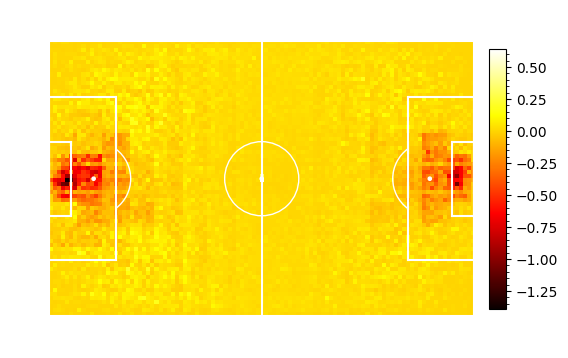

<Axes: >

In [ ]:
import matplotsoccer as mps
import numpy as np

heatmap_grid = np.zeros((68, 105))
for _, action in df_mov_actions.iterrows():
    start_x = int(action["start_x"])
    start_y = int(action["start_y"])
    if 0 <= start_x < 105 and 0 <= start_y < 68:
        heatmap_grid[start_y, start_x] += action["xT_value"]

# Plot the heatmap
mps.heatmap(heatmap_grid, cmap="hot", linecolor="white", cbar=True)